## Cross-in-Plane Graph Density of States Plots

**_NOTE_:** This script is written using the `PythonBasics` environment.

Estimate the Integrated Density of States (IDoS) and Density of States (DoS) from the dispersion relation
\begin{align}
    \cos(\omega) + \frac{\alpha\omega}{4}\sin(\omega) = \cos\left( \frac{\theta_1-\theta_2}{2} \right) \cos\left( \frac{\theta_1+\theta_2}{2} \right). \qquad (*)
\end{align}
Here, $\alpha<0$, $\omega\geq0$, and $\theta\in[-\pi,\pi)^2$.

The integrated density of states $\mathcal{I}_n$ for each spectral band $I_n$ is defined as follows;
\begin{align*}
    \mathcal{I}_n(x) &= \lambda_2 \left( \{ \theta \ \vert \ (\omega, \theta) \text{ solves } (*) \text{ where } \omega \leq x, \omega\in I_n \} \right).
\end{align*}
The density of states $\mathcal{D}_n$ for each band is then computed by differentiating;
$$ \mathcal{D}_n(x) = \dfrac{\mathrm{d}\mathcal{I}_n}{\mathrm{d}x}(x). $$

Let us define
\begin{align*}
    \Psi(\omega) &= \cos\omega + \frac{\alpha\omega}{4}\sin\omega, \\
    \Phi(\theta) &= \cos\theta_1 + \cos\theta_2.
\end{align*}
We know that, for $n\in\mathbb{N}$,
\begin{align*}
    \Psi(n\pi)=(-1)^n, \quad
    \Psi'(n\pi) = \left\lvert \frac{\alpha n\pi}{4} \right\rvert (-1)^{n+1},
\end{align*}
and since $-1 \leq \phi(\theta) \leq 1$ for all $\theta$, we know that $n\pi$ marks the end of each spectral band $I_n$.
We also know that there exists a $c_n\in\left((n-1)\pi,n\pi\right)$ such that $\Psi(c_n)=(-1)^{n-1}$, and thus the spectral band $I_n = \left(c_n, n\pi \right)$.
Note that the right-endpoint of $I_n$ might be closed, depending on whether $n$ is odd or even.
Finally, we can see that $\Psi$ is either strictly increasing ($n$ even) or strictly decreasing ($n$ odd) over the spectral band $I_n$.

Next, let $x\in I_n$.
Note that $\mathcal{I}(x)=0$ whenever $x<y$.
Otherwise, we can use our information about $\Psi$ to note that
\begin{align*}
    m_n := \min_{[c_n,x]}\Psi &= \begin{cases} \psi(x) & n \text{ odd}, \\ \psi(c_n) & n \text{ even}. \end{cases}
    \\
    M_n := \max_{[c_n,x]}\Psi &= \begin{cases} \psi(c_n) & n \text{ odd}, \\ \psi(x) & n \text{ even}. \end{cases}
\end{align*}
Then using $(*)$, we just need to compute the area of the region $\theta$ such that
\begin{align*}
    & m_n \leq \cos\left( \frac{\theta_1-\theta_2}{2} \right) \cos\left( \frac{\theta_1+\theta_2}{2} \right) \leq M_n, \\
    \Rightarrow & 2m_n \leq \Phi(\theta) \leq 2M_n. \qquad (**)
\end{align*}
To do so, we can just take a suitable "mesh" for $\theta$, determine whether the inequality holds at each of the mesh-points, and approximate the area by multiplying the number of mesh points $\theta_{xy}$ which satisfy the equation by the "cell area" of the mesh (area of the region whose closest mesh point is $\theta_{xy}$).
We could try to be a bit smarter by actually solving the inequality above for the exact region enclosing admissible $\theta$'s, but I think this is (a) hard and (b) a lot of effort for not much gain.

The plan to determine $\mathcal{I}_n$ is thus as follows;
1. Compute an estimate to $c_n$.
1. Determine $M_n$ and $m_n$.
1. Mesh theta appropriately.
1. Determine mesh points which solve $(**)$.
1. Compute numerical estimate of IDoS, and hence of DoS.

In [1]:
import numpy as np

from scipy.optimize import bisect

import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)

%matplotlib inline

from mpl_toolkits.mplot3d import axes3d

import time

#### `Psi(omega, alpha)`

Computes the value of the left-hand-side (LHS) of the equation $(*)$, for the given value of $\omega=$ `omega` and $\alpha=$ `alpha`.

`omega` may be passed in as a vector, in which case `Psi` will compute the value of the LHS of $(*)$ for each value in `omega`, returning an array of the same shape. 

In [2]:
def Psi(omega, alpha):
    '''
    Computes the LHS of equation (*), for vector omega and scalar alpha
    INPUTS:
        omega: (n,) float numpy array; values of omega to compute LHS of (*) at
        alpha: float; value of alpha to use
    OUTPUTS:
        LHS: (n,) numpy array; values of the LHS of (*) at the values of omega that were given
    '''
    
    LHS = np.cos(omega) - (alpha * omega * np.sin(omega))/4.0
    return LHS

#### `Phi(theta)`

Computes the value of the function $\Phi$ defined above, equivalently half the value of the right-hand-side (RHS) of the equation $(*)$, at the value $\theta$ = `theta`.

`theta` can be of shape `(n,2)`, in which case the function returns a vector of shape `(n,)` with the values of $\Phi$, using each row of `theta` as a pair $\theta_1, \theta_2$.

In [3]:
def Phi(theta):
    '''
    Computes the RHS of equation (*) for theta1, theta2 pairs stored row-wise (theta of shape (n,2))
    INPUTS:
        theta: (n,2) numpy array; quasimomentum pairs stored row-wise
    OUTPUTS:
        RHS: (n,) numpy array; RHS of equation (*) for the theta pairs passed
    '''
    
    if theta.ndim>1:
        RHS = np.sum(np.cos(theta), axis=1)
    else:
        # if theta is of shape (2,), we can't use the np.sum function.
        # we can handle this case here, however if we know that a shape (2,) is being passed in, we can also handle
        # it by passing in np.array([theta]) instead.
        if theta.ndim==1:
            RHS = np.sum(np.cos(theta))
        else:
            raise AxisError('theta must be of shape (n,2) or shape (2,), got', theta.shape)
    return RHS    

#### `FindBandMin(bandN, alpha, expMax)`

Computes the left-end-point of the band $I_{\text{bandN}}$, given that $\alpha=$ `alpha`. `expMax` is a loop-breaker for when we need to determine a suitable left-starting point for the binary search.

Computing the left-end-point of the band $I_n$ is relatively simple: we are simply solving for $\Psi(\omega, \alpha) = (-1)^{n-1}$.
We also know that a root must exist in the region $((n-1)\pi, n\pi)$, and $\Psi$ is continuous, so binary search is perfectly applicable.

One slight complication is that we cannot start the binary search using the left-endpoint $(n-1)\pi$, since $(n-1)\pi$ will be immediately returned as the answer.
However this is the right-end of the band $I_{n-1}$ rather than the left-end of the band $I_n$.
As such, we must move the left-starting point of the binary search to a value slightly greater than $(n-1)\pi$, but whilst retaining the same sign as $\Psi((n-1)\pi)$.
To so do, we just take the first such applicable point of the form $(n-1)\pi + 10^{-j}$, where $j$ is successively increased from $0$ through `expMax-1`.

In [4]:
def FindBandMin(bandN, alpha, expMax=8):
    '''
    Given the index n of a band, and the value of alpha to use, compute the value c_n denoting the left-end-point
    of the band I_n.
    INPUTS:
        bandN: int; the index n of the band I_n of which we want to determine the left endpoint
        alpha: float; the value of alpha in (*)
        expMax: int (default 8); minimum exponent for nudge from (n-1)pi in binary search start
    OUTPUTS:
        c: float; approximation to the left enpoint of the band I_n = [c, n*pi]
    '''
    
    # first, if alpha >=-2 and bandN=1, the first band starts at 0, so we should just escape
    if ( (bandN==1) and (alpha>=-2.0) ):
        return 0
    elif alpha>=0.0:
        # if alpha>=0, the bands START at (n-1)*pi and terminate at some value prior to n*pi,
        # so return (bandN-1)*pi
        return (bandN-1)*np.pi
    # otherwise, we'll need to estimate the left endpoint via a binary search
    
    # we find the left-endpoint of the spectral band I_n via binary search,
    # Psi is continuous, and we know that Psi(n\pi) and Psi((n-1)\pi) have different signs (are even +/-1).
    # we just need to make sure that we either subtract or add one to Psi to find the left-endpoint
    if bandN%2==0:
        # if bandN is even, Psi(n\pi) = 1, so we are looking for when Psi = -1
        f = lambda x: Psi(x, alpha=alpha) + 1
        fEnd = -1.0
    else:
        # bandN is odd, Psi(n\pi) = -1, so we are looking for when Psi = 1
        f = lambda x: Psi(x, alpha=alpha) - 1
        fEnd = 1.0
    # we can't bisect starting at (bandN-1)*np.pi, since this will be taken as the answer,
    # however it is the right-end of the previous band, not the left-end of this band.
    # the cheeky hack is just to start by adding on a small value to (bandN-1)*np.pi, 
    # so that we are always "pushed" away from it
    for i in range(expMax):
        nudged = (bandN-1) * np.pi + 1./(10.**i)
        if ( fEnd * f(nudged) ) > 0:
            # these points have the same sign, so we can binary search from nudged instead
            break
        elif i==7:
            raise ValueError('Could not nudge to find left-endpoint of band %d' % (bandN))
    c = bisect(f, nudged, bandN*np.pi)
    
    return c

#### `IsBetween(values, a, b)`

Determines whether the inequality `a` $\leq$ `values` $\leq$ `b` holds, returning a `True` or `False` value.

If `values` is an array, the inequality will be checked for every value in `values`, and the output will be an array of `True/False` values with the element-wise result.

In [5]:
def IsBetween(values, a, b):
    '''
    Checks whether the inequality a <= values <= b is satisfied, returning a boolian True/False value.
    If values is a vector, the function operates element-wise and returns a boolian array.
    INPUTS:
        values: float or numpy array
        a: float; lower bound for values
        b: float; upper bound for values, should be greater than a
    OUTPUTS:
        tf: bool of same shape as values; True/False values indicating whether the inequality was satisfied
    '''   
    midPoint = (a+b) / 2.0
    halfDiff = (b-a) / 2.0
    tf = np.abs(values - midPoint) <= halfDiff
    
    return tf

#### `CreateBandIDoS(t1Pts, t2Pts, bandN, alpha)`

Creates the IDoS function $\mathcal{I}_{\mathrm{bandN}}$ for the band $I_{\mathrm{bandN}}$, with the given value of $\alpha$ and using a `t1Pts` $\times$ `t2Pts` mesh in $\theta$.

The mesh created for $\theta$ is always uniform in each dimension, although the mesh "step" in each dimension can be different if desired.

Using the created mesh, the midpoints $\theta_m$ are determined, and $\Phi$ is evaluated at every pair of midpoints in $\theta_m$.
The idea is that, if a certain $\theta^*_m$ satisfies $(*)$, we approximate this as meaning all values of $\theta$ whose closest midpoint is $\theta^*_m$ also satisfy $(*)$.
This gives us an "area" in $\theta$-space which contributes to the value of $\mathcal{I}_{\mathrm{bandN}}$.

Then, for each $x$ and `bandN`, we can approximate $\mathcal{I}_{\mathrm{bandN}}$ by computing the bounds in $(**)$ and summing over the contributing $\theta_m$.
Obviously, the approximation gets better with more meshpoints, and the quality of the approximation to $\mathcal{D}_{\mathrm{bandN}}$ also depends greatly on the "mesh step" in $\theta$.

`**kwargs`:
- expMax: passed to `FindBandMin`

##### Functions created by this function: 
`IDosN(x)`

Computes the value of $\mathcal{I}_{\mathrm{bandN}}$ at the value `x`.
`x` may be passed in as a vector of values, in which case `IDosN` returns a vector of the same shape with element-wise evaluation.

In [6]:
def CreateBandIDoS(t1Pts, t2Pts, bandN, alpha, **kwargs):
    '''
    Create a function handle to evaluate IDoS for the given band, at the value of alpha provided.
    Use a mesh in theta constructed from t1Pts-by-t2Pts vertices.
    INPUTS:
        t1Pts, t2Pts: int; number of meshpoints to use in each dimension of theta
        bandN: int; index n of the spectral band we want the IDoS for
        alpha: float; value alpha in (*) and (**)
    OUTPUTS:
        IDosN: function; the function IDoS(x) for this band
        dt: (2,) numpy array; the mesh-step in each dimension of theta
    **kwargs:
        expMax: passed to FindBandMin
    '''

    # determine mesh for theta
    t1Splits = np.linspace(-np.pi, np.pi, t1Pts)
    t2Splits = np.linspace(-np.pi, np.pi, t2Pts)
    # determine the centres of the "squares" that we are breaking [-pi, pi) into
    t1Mids = (t1Splits[1:] + t1Splits[:-1]) / 2.
    t2Mids = (t2Splits[1:] + t2Splits[:-1]) / 2.
    # create an array of pairs of thetas, from the midpoints
    thetaPairs = np.array(np.meshgrid(t1Mids, t2Mids)).T.reshape(-1,2)
    # this is the "mesh step" in each dimension of theta
    dt = np.array([t1Splits[1]-t1Splits[0], t2Splits[1]-t2Splits[0]])
    # compute "area" around each meshpoint, uniform mesh so only one value is to be computed
    pointArea = np.prod(dt)
    # now, evaluate Phi at each theta pair
    phiVals = Phi(thetaPairs)

    # now, for a given bandN and x\in[c_n, n*pi], we just need to check how many entries in phiVals satisfy
    # equation (**)
    if 'expMax' in kwargs.items():
        c = FindBandMin(bandN, alpha, expMax=kwargs['expMax'])
    else:
        c = FindBandMin(bandN, alpha)

    # create function handles - remember that the bandID will affect whether Psi(x) is the max or min value in
    # (**)
    if bandN%2==0:
        # I_n with n even
        mn = Psi(c, alpha)
        # create IDoS function
        def IDosN(x):
            '''
            Integrated density of states (IDoS) for the band I_{bandN}
            '''
            Mn = Psi(x, alpha)
            iDosVal = np.zeros_like(x)
            for i, M in enumerate(Mn):
                goodTheta = IsBetween(phiVals, 2.*mn, 2.*M)
                iDosVal[i] = np.sum(goodTheta) * pointArea
            # cleanup "outside band" possibilities
            iDosVal[x < c] = 0.
            iDosVal[x > bandN*np.pi] = (2.*np.pi)**2
            return iDosVal
    else:
        # I_n with odd n
        Mn = Psi(c, alpha)
        # create IDoS function
        def IDosN(x):
            '''
            Integrated density of states (IDoS) for the band I_{bandN}
            '''        
            mn = Psi(x, alpha)
            iDosVal = np.zeros_like(x)
            for i, m in enumerate(mn):
                goodTheta = IsBetween(phiVals, 2.*m, 2.*Mn)
                iDosVal[i] = np.sum(goodTheta) * pointArea
            iDosVal[x < c] = 0.
            iDosVal[x > bandN*np.pi] = (2.*np.pi)**2
            return iDosVal
    
    #return the created function handle and dt
    return IDosN, dt

#### `CreateBandDoS(IDosN, t1Pts, t2Pts)`

Creates the function $\mathcal{D}$ using finite differences and the function $\mathcal{I}_{n}$ (that evaluates an IDoS) which is passed in.

We can compute $\mathcal{D}_n$ from $\mathcal{I}_{n}$ using finite differences, since
\begin{align*}
    \mathcal{D}_n &= \dfrac{\mathrm{d}\mathcal{I}_n}{\mathrm{d}x} \\
    &= \lim_{dx\rightarrow 0} \frac{\mathcal{I}_n(x + dx) - \mathcal{I}_n(x)}{dx},
\end{align*}
for a suitably small $dx$, we can numerically estimate the limit.

The value $dx$ that is used is computed from looking at the mesh in $\theta$ (constructed from `t1Pts` and `t2Pts` as in `CreateBandIDoS`) and determining the maximum difference between subsequent values of $\Phi$.
This serves as an approximation for "how discrete" the values $\mathcal{I}_{n}$ returns are - namely, the change in $x$ required to produce a change in $\mathcal{I}_{n}(x)$, due to the discretisation of $\theta$.

##### Functions created by this function: 
`DosN(x)`

Computes the value of $\mathcal{D}_{n}$ at the value `x`.
`x` may be passed in as a vector of values, in which case `DosN` returns a vector of the same shape with element-wise evaluation.

In [7]:
def CreateBandDoS(IDosN, t1Pts, t2Pts):
    '''
    Create a function handle to evaluate DoS given the IDoS passed in.
    Use finite differences to estimate the derivative that is involved.
    INPUTS:
        IDosN: function (x); evaluates the IDoS for some band at some value of alpha, output of CreateBandIDoS
        t1Pts, t2Pts: int; number of meshpoints to use in each dimension of theta when checking if the finite
        difference approximation will produce good results.
    OUTPUTS:
        DosN: function; the function DoS(x) for this band
        dx: float; the finite-difference step used to approximate derivatives
    '''
    
    # construct the theta meshes as for IDos, in order to find appropriate finite difference step 
    t1Splits = np.linspace(-np.pi, np.pi, t1Pts)
    t2Splits = np.linspace(-np.pi, np.pi, t2Pts)
    t1Mids = (t1Splits[1:] + t1Splits[:-1]) / 2.
    t2Mids = (t2Splits[1:] + t2Splits[:-1]) / 2.
    thetaPairs = np.array(np.meshgrid(t1Mids, t2Mids)).T.reshape(-1,2)
    # now, evaluate Phi at each theta pair, and take the difference between values
    phiVals = Phi(thetaPairs)
    phiDiffs = np.abs(phiVals[1:] - phiVals[:-1])
    # we will use dx = max. difference in phiDiffs between subsequent values
    # as an approximation to the infinitesimal in the definition of derivative
    dx = np.max(phiDiffs)

    # create the function handle
    def DosN(x):
        '''
        Density of states (DoS), created using CreateBandDoS.
        '''
        bandDos = ( IDosN(x + dx) - IDosN(x) ) / dx
        return bandDos
    # return function and finite-step value
    return DosN, dx

#### `BandPlotValues(bandN, bandPts, alpha, t1Pts, t2Pts, iNormalise)`

For the band with $n=$ `bandN`, construct the arrays which will be used to plot the band's IDoS, DoS, and contribution to the spectrum.

The values of the IDoS are be normalised (by $(2\pi)^2$) by default - this can be toggled using the `iNormalise` variable.

The values of `t1Pts` and `t2Pts` are passed into the contructor functions `CreateBandIDoS` and `CreateBandDoS`, but have default values of 1000 as this is a relatively good speed/quality trade-off.

In [8]:
def BandPlotValues(bandN, bandPts, alpha, t1Pts=1000, t2Pts=1000, iNormalise=True):
    '''
    Construct the arrays for a given band which will be used for plotting the IDoS, DoS, and spectrum.
    INPUTS:
        bandN: int; band number
        bandPts: int; the number of points x to break the interval [(bandN-1)pi, bandN*pi] into
        alpha: float; value of alpha in (*) and (**)
        t1Pts, t2Pts: numpy array (default 1000); passed to CreateBandIDoS and CreateBandDoS
        iNormalise: bool (default True); if True, the IDoS values will be normalised by (2pi)^2
    OUTPUTS:
        xRange: (bandPts,) numpy array; values of omega (or x) used for evaluation
        iDosVals: (bandPts,) numpy array; values of the IDoS
        dosVals: (bandPts,) numpy array; values of the DoS
        psiGood: (bandPts,) numpy array; boolian values as to whether each given x lies in the spectrum
    '''
    
    # create the values in this band that we'll need to evaluate IDoS and DoS at
    xRange = np.linspace((bandN-1)*np.pi, bandN*np.pi, bandPts)
    # get the function handles for DoS and IDoS
    IDosN, dt = CreateBandIDoS(t1Pts, t2Pts, bandN, alpha)
    DosN, dx = CreateBandDoS(IDosN, t1Pts, t2Pts)
    # compute values of DoS and IDoS
    # if iNormalise, we should normalise the IDoS values by dividing by (2pi)^2
    if iNormalise:
        iDosVals = IDosN(xRange)/(2.*np.pi)**2
    else:
        iDosVals = IDosN(xRange)
    dosVals = DosN(xRange)
    # finally, compute values for which -1 <= Psi(x) <= 1
    psiVals = Psi(xRange, alpha)
    psiGood = np.zeros_like(xRange, dtype=float)
    psiGood[IsBetween(psiVals, -1., 1.)] = 1.0
    psiGood[0] = 0.0
    
    return xRange, iDosVals, dosVals, psiGood

#### `CreatePlots(lastBand, bandPts, alpha, firstBand=1, labels='Paper', t1Pts=1000, t2Pts=1000, iNormalise=True)`

Create a plot of $\mathcal{I}$, the spectrum, and $\mathcal{D}$ on a shared $\omega$-axis, from the beginning of the band `firstBand` to the beginning of the band `lastBand`.
Note that this means that bands `firstBand` through `lastBand-1` are plotted.
The value of $\alpha$ in $(*)$ and $(**)$ must be passed in, along with the number of points (per band) to discretise the $\omega$ axis into.
The optional argument `labels` defaults to a string `Paper`, which ensures that the plot uses the same formatting for it's axis labels and title as intended for the `Paper_Scalar2020` file.
The other set of labels used (when `labels` is set to anything else) uses the notation established in this notebook.

Multiple optional arguments are accepted, so that they can be passed into functions which are called by this function during the creation of the plot (and creation of data for the plot).
These include:
- `t1Pts` and `t2Pts`; passed to `CreateBandIDoS` and `CreateBandDoS`
- `iNormalise`; passed to `BandPlotValues`

In [9]:
def CreatePlots(lastBand, bandPts, alpha, firstBand=1, labels='Paper', t1Pts=1000, t2Pts=1000, iNormalise=True):
    '''
    Create a plot of the IDoS, DoS, and spectrum on a shared omega-axis, for the given value of alpha 
    and from the beginning of band firstBand to the beginning of band lastBand.
    Note that this means lastBand itself is not included in the plot.
    INPUTS:
        lastBand: int; index of the band, at the beginning of which the plot range ends
        bandPts: int; number of discrete points to divide the interval [(n-1)pi, n*pi] into for plotting each band
        alpha: float; value alpha in (*) and (**)
        firstBand: int (default 1); index of the band at which the plot begins
        labels: float (default 'Paper'); format selection for axis labels in the plots produced. Paper also changes the label of alpha to alpha_3
        t1Pts, t2Pts: int (default 1000); passed to CreateBandIDoS and CreateBandDoS
        iNormalise: bool (default True); passed to BandPlotValues
    OUTPUTS:
        fig, ax: matplotlib handles; the matplotlib figure produced
    '''
    
    # the number of points in total that will be in the plot is determined by
    # (lastBand - firstBand)*(bandPts - 1) + 1
    # IE; bandPts - 1 for each band (due to the duplicate entry at the left of each band),
    # + 1 to account for the first band to plot having no band on it's left so retaining the left-endpoint
    nPtsTotal = (lastBand - firstBand)*(bandPts - 1) + 1
    # now create the arrays which will store the values...
    xRangeStore = np.zeros((nPtsTotal), dtype=float)
    iDoSStore = np.zeros((nPtsTotal), dtype=float)
    doSStore = np.zeros((nPtsTotal), dtype=float)
    specStore = np.zeros((nPtsTotal), dtype=float)
    
    # store first band information
    print('Working on band %d' % firstBand, end=': ')
    st = time.time()
    x1, i1, d1, s1 = BandPlotValues(firstBand, bandPts, alpha, t1Pts=t1Pts, t2Pts=t2Pts, iNormalise=iNormalise)
    ft = time.time()
    print('completed in %s seconds' % (ft-st))
    xRangeStore[:bandPts] = x1
    iDoSStore[:bandPts] = i1
    doSStore[:bandPts] = d1
    specStore[:bandPts] = s1
    # loop over every other band to be plotted, removing the left-endpoint as a duplicate
    for n in range(firstBand+1, lastBand):
        storeStart = bandPts + (bandPts-1)*(n-firstBand-1)
        print('Working on band %d' % n, end=': ')
        st = time.time()
        xN, iN, dN, sN = BandPlotValues(n, bandPts, alpha, t1Pts=t1Pts, t2Pts=t2Pts, iNormalise=iNormalise)
        ft = time.time()
        print('completed in %s seconds' % (ft-st))
        xRangeStore[storeStart:storeStart+bandPts-1] = xN[1:]
        iDoSStore[storeStart:storeStart+bandPts-1] = iN[1:]
        doSStore[storeStart:storeStart+bandPts-1] = dN[1:]
        specStore[storeStart:storeStart+bandPts-1] = sN[1:]
    # we should now have the master arrays, which we can now assemble into the plots...
    
    print('Creating plot', end=': ')
    st = time.time()
    fig, ax = plt.subplots(3, sharex=True, gridspec_kw={'hspace': 0.5})

    ax[0].plot(xRangeStore/np.pi, iDoSStore)
    ax[1].scatter(xRangeStore/np.pi, specStore, s=3., marker='x', c='red')
    ax[1].set_ylim(0.5,1.5)
    ax[2].plot(xRangeStore/np.pi, doSStore)
    if labels=='Paper':
        ax[0].set_title(r'IDoS, spectrum, and DoS, $\alpha_3=%.2f$' % (alpha))
        ax[0].set_ylabel(r'$\frac{\mathrm{IDoS} \ \mathrm{(rel.)}}{(2\pi)^{2}}$')
        ax[1].set_ylabel(r'Spectrum')
        ax[2].set_xlabel(r'$\frac{\omega}{\pi}$')
        ax[2].set_ylabel(r'$\mathrm{DoS}$')
    else:
        ax[0].set_title(r'IDoS, spectrum, and DoS, $alpha=%.3f$' % (alpha))
        ax[0].set_ylabel(r'$\frac{\mathcal{I}}{(2\pi)^2}$')
        ax[1].set_ylabel(r'Spectrum')
        ax[2].set_xlabel(r'$\frac{\omega}{\pi}$')
        ax[2].set_ylabel(r'$\mathcal{D}$')
    ft = time.time()
    print('completed in %s seconds' % (ft-st))
    
    return fig, ax

#### `DispRelPlot(lastBand, bandPts, alpha, firstBand, labels)`

Creates a plot of the function $\Psi$ above, for the given value of $\alpha$.
The extent of the plot on the $\omega$-axis is the beginning of the band with index `firstBand`, through to the beginning of the band `lastBand`.
The optional argument `labels` defaults to a string `Paper`, which ensures that the plot uses the same formatting for it's axis labels and title as intended for the `Paper_Scalar2020` file - including the alias change from $\Psi$ to $\Xi$ for the function we are plotting.
The other set of labels used (when `labels` is set to anything else) uses the notation established in this notebook.

The plot consists of the function $\Psi$ itself, a scatter plot of the spectrum of the function, and two horizontal bars indicating the values $\pm 1$, to show which portions of $\Psi$ correspond to eigenvalues.

In [10]:
def DispRelPlot(lastBand, bandPts, alpha, firstBand=1, labels='Paper'):
    '''
    Creates a plot of the function $\Psi$ defined above, in Paper_Scalar2020 this function is labelled $\Xi$.
    INPUTS:
        lastBand: int; index of the band, at the beginning of which the plot range ends
        bandPts: int; number of discrete points to divide the interval [(n-1)pi, n*pi] into for plotting each band
        alpha: float; value alpha in (*) and (**)
        firstBand: int (default 1); index of the band at which the plot begins
    OUTPUTS:
        fig, ax: matplotlib handles; the matplotlib figure produced
    '''
    
    xRange = np.linspace(0, (lastBand-1)*np.pi, (lastBand-firstBand)*bandPts, endpoint=False)
    psiVals = Psi(xRange, alpha)
    spec = np.zeros_like(xRange, dtype=int)
    spec[IsBetween(psiVals, -1., 1.)] = 1
    
    fig, ax = plt.subplots()
    ax.plot(xRange/np.pi, psiVals, 'blue')
    ax.plot(xRange/np.pi, np.ones_like(psiVals), 'black')
    ax.plot(xRange/np.pi, -np.ones_like(psiVals), 'black')
    ax.scatter(xRange[IsBetween(psiVals, -1., 1.)]/np.pi, np.zeros_like(xRange[IsBetween(psiVals, -1., 1.)]), \
              s=3., marker='x', c='red')
    ax.set_xlabel(r'$\frac{\omega}{\pi}$')
    if labels=='Paper':
        ax.set_title(r'$\Xi(\omega), \ \alpha_3=%.2f $' % (alpha))
        ax.set_ylabel(r'$\Xi(\omega)$')
    else:
        ax.set_title(r'$\Psi(\omega), \ \alpha=%.2f $' % (alpha))
        ax.set_ylabel(r'$\Psi(\omega)$')  
    
    return fig, ax

### Script to Generate Figures for Paper

The cell below generates the figures which are to be used in the file `Paper_Scalar2020.tex`.
These are saved to the subfolder `./images` of the directory this notebook is saved in - they will need to be manually moved to the `Diagrams/Numerical_Results` folder before they can be accessed by the `.tex` files.

At present, we create plots of:
- The function $\Psi$ (or $\Xi$ in the paper notation) for $\alpha=1$ and $\alpha=4$, up to the beginning of band 6
- The IDoS, DoS, and spectrum for $\alpha=1$ and $\alpha=4$, up to the beginning of band 4

Creating plots of Psi(x):
    Creating plot for alpha=1.00


/home/will/anaconda3/envs/PythonBasics/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


    Creating plot for alpha=4.00


/home/will/anaconda3/envs/PythonBasics/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


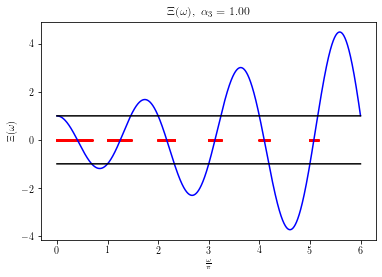

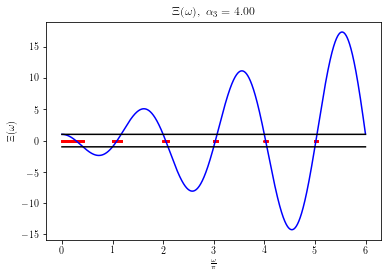

In [11]:
print('Creating plots of Psi(x):')
firstBand = 1
lastBand = 7
bandPts = 1000
for alpha in [1.0, 4.0]:
    print('    Creating plot for alpha=%.2f' % (alpha))
    fig, ax = DispRelPlot(lastBand, bandPts, alpha, firstBand=1, labels='Paper')
    saveStrDot = './images/CrossInPlane_ScalarDR_alpha' + '{0:.2f}'.format(alpha) + '.pdf'
    saveStrDot = list(saveStrDot)
    saveStrDot[-7] = '-' #changes decimal point to dash for compatability issues
    saveStr = ''
    for c in saveStrDot:
        saveStr += c
    fig.savefig(saveStr, bbox_inches='tight')
    fig.show()

Creating plots of IDoS and DoS:
    Creating plot for alpha=1.00
Working on band 1: completed in 13.241904020309448 seconds
Working on band 2: completed in 14.53175163269043 seconds
Working on band 3: completed in 14.487474203109741 seconds
Working on band 4: completed in 14.594539165496826 seconds
Creating plot: completed in 0.05254554748535156 seconds


/home/will/anaconda3/envs/PythonBasics/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


    Creating plot for alpha=4.00
Working on band 1: completed in 15.055887222290039 seconds
Working on band 2: completed in 13.993725061416626 seconds
Working on band 3: completed in 14.43994665145874 seconds
Working on band 4: completed in 14.304215908050537 seconds
Creating plot: completed in 0.05174899101257324 seconds


/home/will/anaconda3/envs/PythonBasics/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


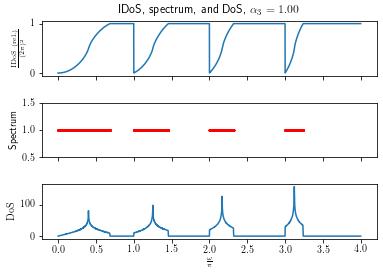

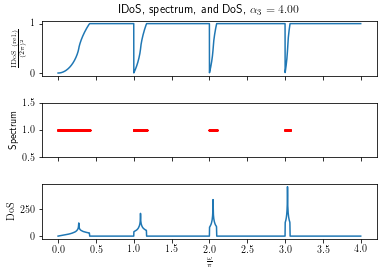

In [12]:
print('Creating plots of IDoS and DoS:')
firstBand = 1
lastBand = 5
bandPts = 1000
for alpha in [1.0, 4.0]:
    print('    Creating plot for alpha=%.2f' % (alpha))
    fig, ax = CreatePlots(lastBand, bandPts, alpha, firstBand=1, labels='Paper')
    saveStrDot = './images/CrossInPlane_ScalarDoS_alpha' + '{0:.2f}'.format(alpha) + '.pdf'
    saveStrDot = list(saveStrDot)
    saveStrDot[-7] = '-' #changes decimal point to dash for compatability issues
    saveStr = ''
    for c in saveStrDot:
        saveStr += c
    fig.savefig(saveStr, bbox_inches='tight')
    fig.show()